In [2]:
import pandas as pd

# 將每季累計的財務數據改成單季的數據
def toSeasonal(df):
    season4 = df[df.index.month == 3]
    season1 = df[df.index.month == 5]
    season2 = df[df.index.month == 8]
    season3 = df[df.index.month == 11]

    season1.index = season1.index.year
    season2.index = season2.index.year
    season3.index = season3.index.year
    season4.index = season4.index.year - 1

    newseason1 = season1
    newseason2 = season2 - season1.reindex_like(season2)
    newseason3 = season3 - season2.reindex_like(season3)
    newseason4 = season4 - season3.reindex_like(season4)

    newseason1.index = pd.to_datetime(newseason1.index.astype(str) + '-05-15')
    newseason2.index = pd.to_datetime(newseason2.index.astype(str) + '-08-14')
    newseason3.index = pd.to_datetime(newseason3.index.astype(str) + '-11-14')
    newseason4.index = pd.to_datetime((newseason4.index + 1).astype(str) + '-03-31')

    return newseason1.append(newseason2).append(newseason3).append(newseason4).sort_index()


In [3]:
def get_dividend(data):
    if data.date > datetime.date(data.date.year,5,15):
        ori_date = data.date
        data.date = datetime.date(data.date.year,12,31)
        dividend = data.get("CASH",1).iloc[-1]
        data.date = ori_date
        return dividend
    else:
        dividend = data.get("CASH",1).iloc[-1]
        return dividend

In [4]:
def get_RSI_all(series,rg = 'month' ,timeperiod = 6):
    RSI_All = pd.DataFrame()
    price = data.get('收盤價', 400).ffill()
    price = price[series.index]
    if rg =='month':
        month = pd.Series(price.index.month, price.index)
        month = month.diff().shift(-1).fillna(0) != 0
    if rg =='week':
        month = pd.Series(price.index.week, price.index)
        month = month.diff().shift(-1).fillna(0) != 0
    if rg =='day':
        month = pd.Series(price.index.day, price.index)
        month = month.diff().shift(-1).fillna(0) != 0
    for i in price.columns:
        pds1 = price[i][month]
        RSI = talib.RSI(pds1, timeperiod=timeperiod)
        RSI = pd.DataFrame(RSI, columns=[i])
        RSI_All = pd.concat([RSI_All,RSI], axis=1)
    RSI_All.columns.names = ['stock_id']
    return RSI_All

# 資優生策略

In [5]:
def mystrategy2(data):
    
    #成交量
#     vol = data.get('成交股數',50)
#     vol_5 = vol.rolling(5).mean()
    
    #現金流
#     df1 = toSeasonal(data.get('投資活動之淨現金流入（流出）', 5))
#     df2 = toSeasonal(data.get('營業活動之淨現金流入（流出）', 5))
#     自由現金流 = (df1 + df2).iloc[-4:].mean()
    
    #ROE
    #股東權益，有兩個名稱，有些公司叫做權益總計，有些叫做權益總額
    #所以得把它們抓出來
    #並且把它們合併起來
    #     稅後淨利 = data.get('本期淨利（淨損）', 1)
    #     權益總計 = data.get('權益總計', 1)
    #     權益總額 = data.get('權益總額', 1)
    #     權益總計.fillna(權益總額, inplace=True)
    #     股東權益報酬率 = 稅後淨利.iloc[-1] / 權益總計.iloc[-1]
    
    股本 = data.get('股本合計', 1)#.drop_duplicates(['stock_id', 'date'], keep='last')#.pivot(index='date', columns='stock_id')
    price = data.get('收盤價', 400)
    #     當天股價 = price[:股本.index[-1]].iloc[-1]
    #     當天股本 = 股本.iloc[-1]
    #     市值 = 當天股本 * 當天股價 / 10 * 1000
    #月K:季線、半年線、年線
    month = pd.Series(price.index.month, price.index)
    month = month.diff().shift(-1).fillna(0) != 0
    price_month = price[month]
    close3_month =price_month.rolling(3).mean()
    close6_month =price_month.rolling(6).mean()
    close12_month =price_month.rolling(12).mean()
    
    #5日、10日、20日均線
    close5 =price.rolling(5).mean()
    close10 =price.rolling(10).mean()
    close20 =price.rolling(20).mean()
    close60 =price.rolling(60).mean()
    #市值營收比
    #     當月營收 = data.get('當月營收', 4) * 1000
    #     當季營收 = 當月營收.iloc[-4:].sum()
    #     市值營收比 = 市值 / 當季營收

    #預估殖利率
    eps = data.get('稀釋每股盈餘合計',8)
    cum_4_eps = eps.fillna(0).rolling(4).sum()
    cum_4_eps_grow = (cum_4_eps.iloc[-1]/cum_4_eps.iloc[-5])
    cum_4_eps_grow = (cum_4_eps_grow*10).apply(np.floor)/10
    預估配息 = (get_dividend(data).astype(float))*cum_4_eps_grow
    預估殖利率 = 預估配息/price.iloc[-1]*100
    
    #營業利益
    營業利益 = data.get('營業利益（損失）', 8)
    cum_4_營業利益 = 營業利益.fillna(0).rolling(4).sum()
    cum_4_營業利益_grow = (cum_4_營業利益.iloc[-1]/cum_4_營業利益.iloc[-5])
    cum_4_營業利益_grow = (cum_4_營業利益_grow*10).apply(np.floor)/10
    
    #月營收成長率
    月營收 = data.get('當月營收', 48)
    月營收 = 月營收[(月營收 != 0)]
#     月營收_3 = 月營收.dropna(axis = 1).rolling(3).sum()
#     月營收_3_grow = 月營收_3.iloc[-1]/月營收_3.iloc[-13]
    月營收_3 = 月營收.dropna(axis = 1).rolling(3).mean()
    月營收_3_grow = 月營收_3/月營收_3.shift(12)
    月營收_3_grow = 月營收_3_grow.rolling(3).mean()
    月營收_12 = 月營收.dropna(axis = 1).rolling(12).mean()
    月營收_12_grow = 月營收_12/月營收_12.shift(12)   
    
    #連三月月營收成長，condition設condition = 連三月成長 即可
    連三月成長 = ((月營收.iloc[-3:]>月營收.shift(12).iloc[-3:]).sum() == 3)
    
    #rsv
    rsv = (price.iloc[-1] - price.iloc[-150:].min()) / (price.iloc[-150:].max() - price.iloc[-150:].min())

    #配息 data.get('CASH', n)，需更改data.date，因此此條件須擺在最後一個順位
    temp_date = data.date
    today = datetime.datetime.now()
    data.date = datetime.datetime(today.year-1,7,1).date()
    dividend_10 = data.get("CASH",10).apply(pd.to_numeric)
    data.date = temp_date
    配息年數 = (dividend_10>0).sum() 
    
#     condition1 = (市值 < 1e10)
#     condition2 = 自由現金流 > 0
#     condition3 = 股東權益報酬率 > 0
#     condition4 = 營業利益成長率 > 0
#     condition5 = 市值營收比 < 3
    condition6 = rsv > 0.5
    condition7 = 配息年數 >= 10
    condition8 = 預估殖利率 > 5
    condition9 = cum_4_營業利益_grow > 0.9
    condition10 = 月營收_12_grow.iloc[-1] > 0.9
    condition11 = 月營收_3_grow.iloc[-1]>月營收_12_grow.iloc[-1]
#     conditionA1 = (close5.iloc[-1] > close20.iloc[-1]*1.01) & (close20.iloc[-1] > close60.iloc[-1]*1.01)
#     conditionA2 = (close10.iloc[-1]> close10.shift(1).iloc[-1])&(close20.iloc[-1]> close20.shift(1).iloc[-1])&(close60.iloc[-1]> close60.shift(1).iloc[-1])
    conditionA3 = (close3_month.iloc[-1] > close6_month.iloc[-1]) 
    conditionA4 = (close12_month.iloc[-1] > close12_month.iloc[-2] ) & (close12_month.iloc[-2] > close12_month.iloc[-3] )
    # 最近一期或去年同期沒有季報都不選，且跟去年同期賺差不多
    conditionB1 = (eps.iloc[-5].notna()) & (eps.iloc[-1].notna()) & (eps.iloc[-1] > eps.iloc[-5]*0.5)
#     conditionC = close5.iloc[-11] < close10.iloc[-11] 
#     conditionD = close10.iloc[-11] < close20.iloc[-11]
#     conditionE = vol_5.iloc[-1]/vol_5.iloc[-6] > 4
                    
    package =  condition7 & condition8 & condition11 & conditionB1

#     if package[package].empty == True:
#         return package[package]
#     else:
#         RSI_month_6 = get_RSI_all(package[package],rg='month',timeperiod=6)
#         RSI_month_12 = get_RSI_all(package[package],rg='month',timeperiod=12)
# #      以上條件篩出後，1.月RSI快線大於慢線，快線連兩月成長、2.月線RSI大於80小於45不買
#         conditionC1 = (RSI_month_6.iloc[-1] > RSI_month_12.iloc[-1])
#         conditionC2 = (100+(RSI_month_12.iloc[-1] - RSI_month_12.iloc[-2])) > 94
#         select_stock = conditionC1 & conditionC2
    pick_stock = 預估殖利率[package[package].index].rank(ascending=False) <= 8
    
    return pick_stock[pick_stock]

### 回測

2007-05-16 - 2007-08-15 報酬率: 0.00 % nstock 0

-----------------------------------------------------
no dividend
-2.4,6.1,2.9,16.1,13.4,9.8,18.1,10.2
2007-08-15 - 2007-11-15 報酬率: 9.26 % nstock 8
4104,5007,5015,5478,5508,5511,5604,8921
-----------------------------------------------------
2007-11-15 - 2008-04-01 報酬率: 0.00 % nstock 0

-----------------------------------------------------
no dividend
37.5,4.7,5.9,9.9,51.3,1.2,5.1,-0.7
2008-04-01 - 2008-05-16 報酬率: 14.36 % nstock 8
3093,3114,4104,4706,5493,5511,5604,8938
-----------------------------------------------------
2008-05-16 - 2008-08-15 報酬率: 0.00 % nstock 0

-----------------------------------------------------
no dividend
-19.9,-19.5,-18.5,2.3,-25.6,-31.7,-65.6,-30.5
2008-08-15 - 2008-11-15 報酬率: -26.12 % nstock 8
3093,4103,4706,5016,5403,5508,5522,6176
-----------------------------------------------------
2008-11-15 - 2009-04-01 報酬率: 0.00 % nstock 0

-----------------------------------------------------
no dividend
29.2,9.6,25.4,

no dividend
32.5,38.4,29.4,-6.0,8.1,64.4,11.1,7.3
2018-11-15 - 2019-04-01 報酬率: 23.13 % nstock 8
1813,2439,2546,2912,3026,3037,3090,5522
-----------------------------------------------------
no dividend
-3.5,16.6,12.2,-8.4,-3.3,-7.5,-1.0,-1.5
2019-04-01 - 2019-05-16 報酬率: 0.45 % nstock 8
1451,1540,1813,2485,2509,2527,8091,8342
-----------------------------------------------------
no dividend
-0.6,0.2,0.2,0.6,0.7,2.5,1.8,0.5
2019-05-16 - 2019-05-20 報酬率: 0.74 % nstock 8
1451,1540,1813,3570,5511,5519,6176,6282
-----------------------------------------------------
每次換手最大報酬 : 26.96 ％
每次換手最少報酬 : -26.12 ％


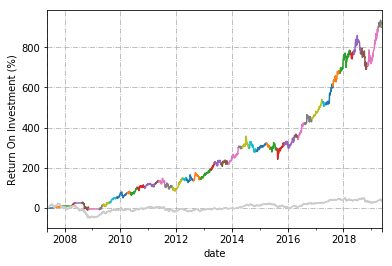

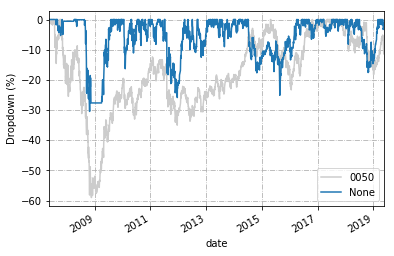

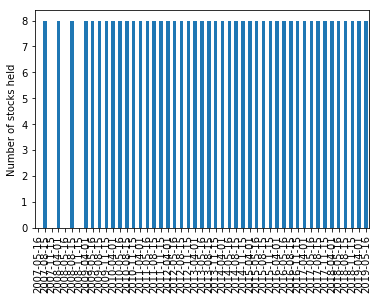

In [6]:
from finlab.backtest import backtest
from finlab.data import Data
import datetime
import matplotlib.pyplot as plt
import warnings
import pandas as pd
import numpy as np
import talib
warnings.simplefilter(action='ignore', category=FutureWarning)
%matplotlib inline

data = Data()

# 起始結束日期
start = datetime.date(2007, 5, 16)
end = datetime.date(2019, 5, 20)
hold_days = [  
    datetime.date(2007, 5, 16),  
    datetime.date(2007, 8, 15),  
    datetime.date(2007, 11, 15),   
    datetime.date(2008, 4, 1),
    datetime.date(2008, 5, 16),
    datetime.date(2008, 8, 15),
    datetime.date(2008, 11, 15),   
    datetime.date(2009, 4, 1),
    datetime.date(2009, 5, 16),
    datetime.date(2009, 8, 15),    
    datetime.date(2009, 11, 15),   
    datetime.date(2010, 4, 1),
    datetime.date(2010, 5, 16),
    datetime.date(2010, 8, 15),     
    datetime.date(2010, 11, 15),   
    datetime.date(2011, 4, 1),
    datetime.date(2011, 5, 16),
    datetime.date(2011, 8, 15),
    datetime.date(2011, 11, 15),    
    datetime.date(2012, 4, 1),
    datetime.date(2012, 5, 16),
    datetime.date(2012, 8, 15),
    datetime.date(2012, 11, 15),    
    datetime.date(2013, 4, 1),
    datetime.date(2013, 5, 16),
    datetime.date(2013, 8, 15),
    datetime.date(2013, 11, 15),    
    datetime.date(2014, 4, 1),
    datetime.date(2014, 5, 16),
    datetime.date(2014, 8, 15),
    datetime.date(2014, 11, 15),    
    datetime.date(2015, 4, 1),
    datetime.date(2015, 5, 16),
    datetime.date(2015, 8, 15),
    datetime.date(2015, 11, 15),    
    datetime.date(2016, 4, 1),
    datetime.date(2016, 5, 16),
    datetime.date(2016, 8, 15),
    datetime.date(2016, 11, 15),    
    datetime.date(2017, 4, 1),
    datetime.date(2017, 5, 16),
    datetime.date(2017, 8, 15),
    datetime.date(2017, 11, 15),    
    datetime.date(2018, 4, 1),
    datetime.date(2018, 5, 16),
    datetime.date(2018, 8, 15),
    datetime.date(2018, 11, 15),
    datetime.date(2019, 4, 1),
    datetime.date(2019, 5, 16),
]

# 課堂上教的回測
eq = backtest(start, end, hold_days, mystrategy2, data)